# 2 peer-reviewed research papers Implementations

## Algorithm 1 (peer-reviewed): HousePrice Predictionand AnalysisBased on RandomForestand XGBoostModels
https://drpress.org/ojs/index.php/HBEM/article/view/14837/14385


In [ ]:
!pip install xgboost -q

Train shape: (1000, 30), Test shape: (460, 30)
Top features: ['OverallQual', 'GrLivArea', 'GarageCars', 'ExterQual', 'GarageArea', 'TotalBsmtSF', '1stFlrSF', 'BsmtQual', 'KitchenQual', 'FullBath', 'TotRmsAbvGrd', 'YearBuilt', 'MasVnrArea', 'GarageYrBlt', 'Fireplaces', 'GarageFinish', 'GarageType', 'HeatingQC', 'BsmtFinSF1', 'Foundation', 'LotFrontage', 'WoodDeckSF', '2ndFlrSF', 'OpenPorchSF', 'BsmtExposure', 'HalfBath', 'LotArea', 'LotShape', 'CentralAir', 'GarageCond']

[RF] Best n_estimators: 85
[RF] Best CV MSE:  1044371972.1734
[RF] Best CV RMSE: 32316.7445

=== Evaluation Metrics (Test Set) – SCALED (standardized SalePrice) ===


,MSE,MAE,RMSE,R2,ExplainedVariance
RandomForest,0.1218,0.2261,0.3491,0.8920,0.8926
XGBoost,0.1136,0.2298,0.3370,0.8993,0.8993



=== RandomForest diagnostics (RAW units) ===
MSE: 738557830.6011, MAE: 17603.6607


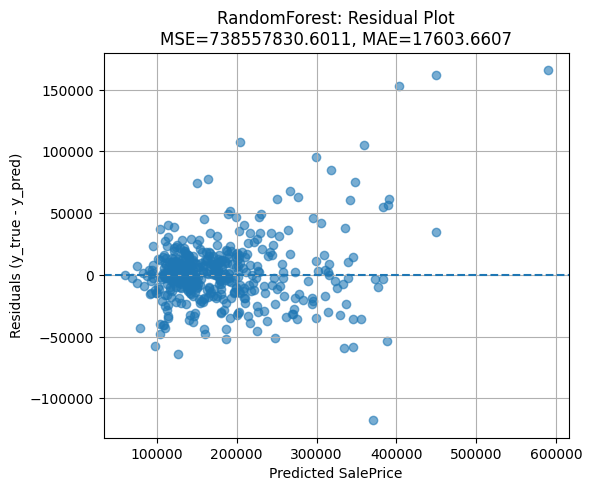

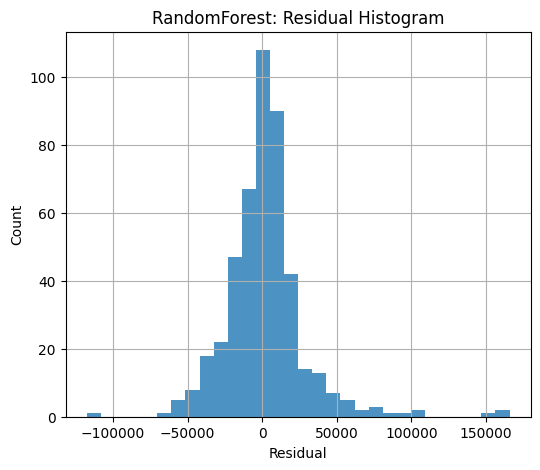


=== XGBoost diagnostics (RAW units) ===
MSE: 688560512.0000, MAE: 17890.7090


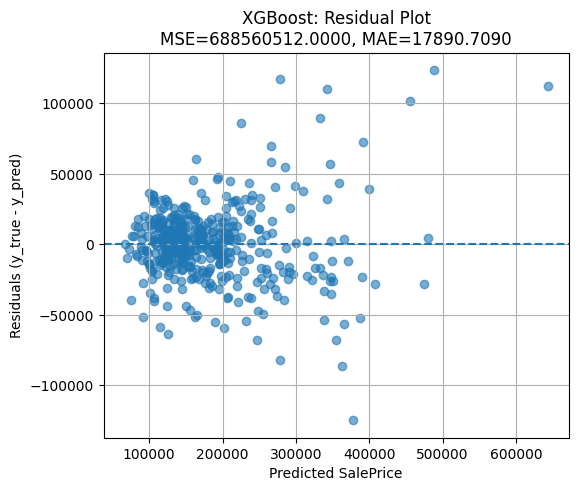

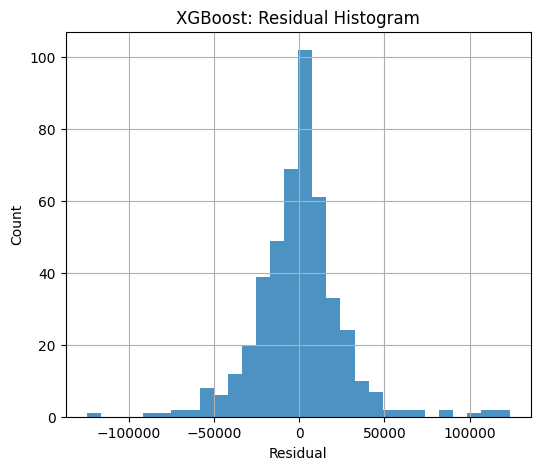

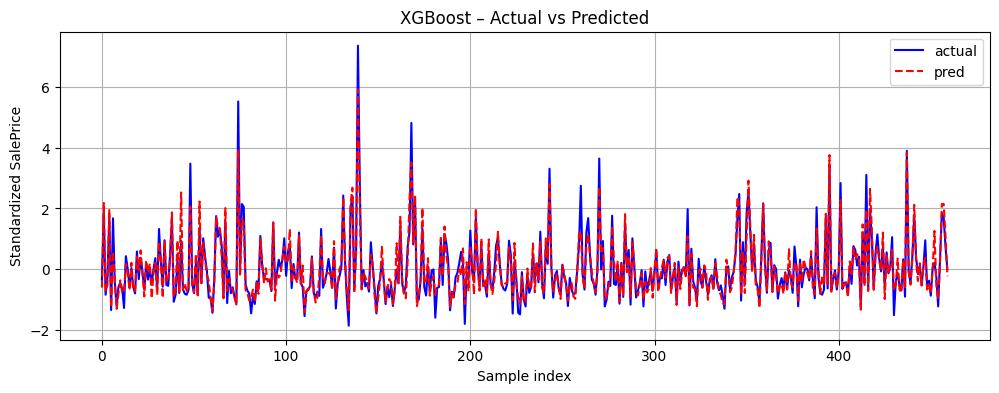

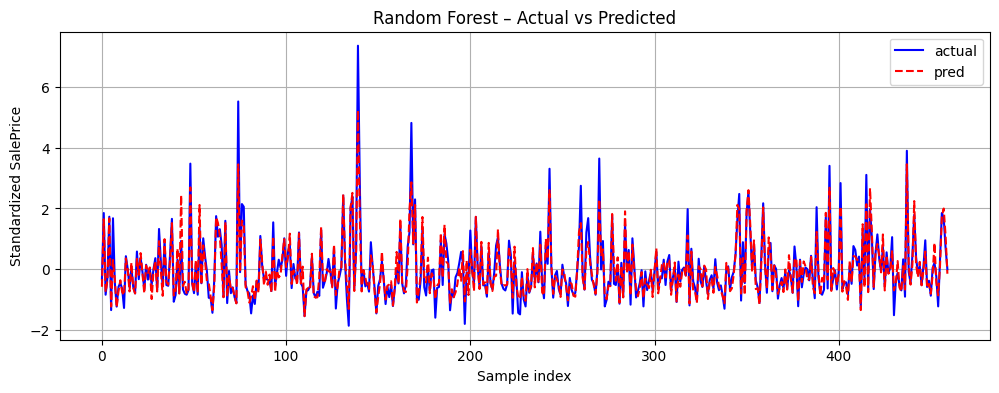

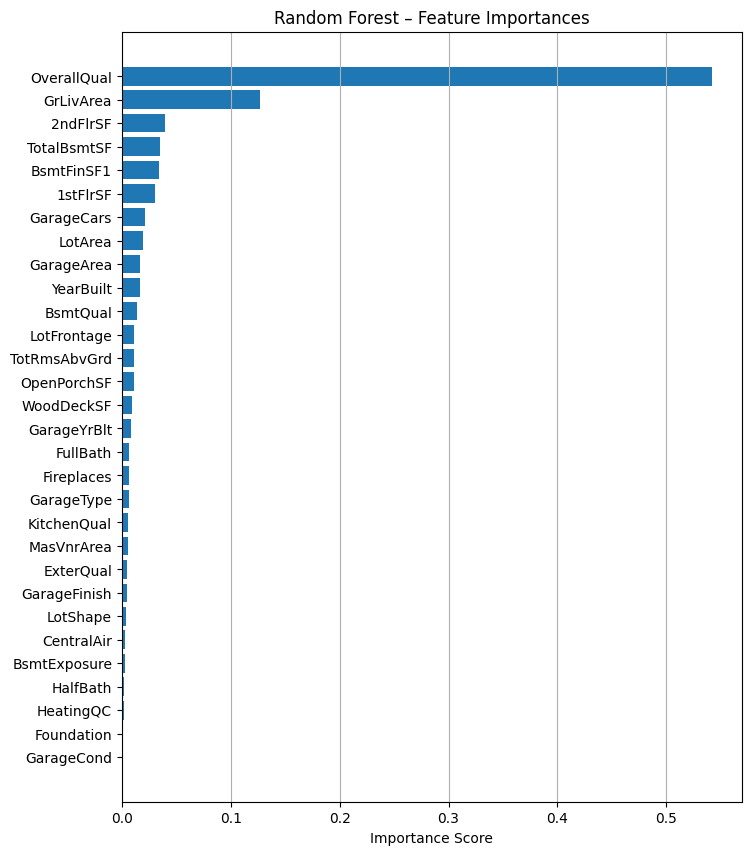

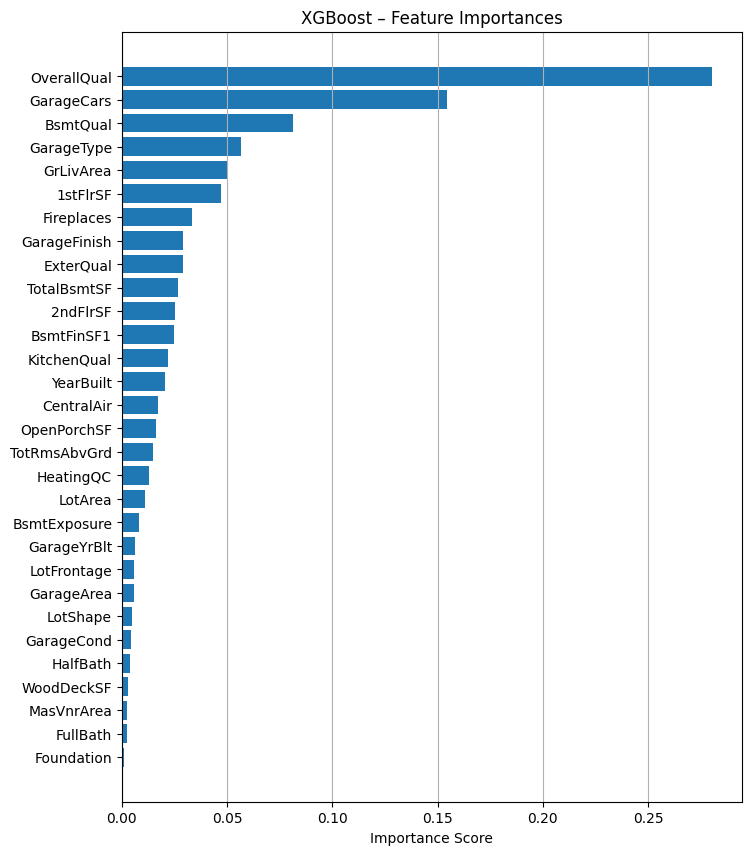

In [ ]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    r2_score,
    explained_variance_score
)

plt.rcParams["figure.figsize"] = (6, 5)
CSV_PATH = "/content/train.csv"

def preprocess_and_split_li2023(csv_path=CSV_PATH, top_k=30, random_state=42):
    df = pd.read_csv(csv_path)

    cols_to_drop = [
        "Alley", "YearRemodAdd", "FireplaceQu", "PoolQC",
        "Fence", "MasVnrType", "MiscFeature", "Id"
    ]
    df = df.drop(columns=[c for c in cols_to_drop if c in df.columns])

    target_col = "SalePrice"
    y = df[target_col]
    X = df.drop(columns=[target_col])
    numeric_cols = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
    categorical_cols = X.select_dtypes(include=["object"]).columns.tolist()
    X[numeric_cols] = X[numeric_cols].apply(lambda col: col.fillna(col.mean()))
    X[categorical_cols] = X[categorical_cols].fillna("NONE")
    encoder = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)
    if categorical_cols:
        X[categorical_cols] = encoder.fit_transform(X[categorical_cols])
    scaler = StandardScaler()
    X_scaled = pd.DataFrame(
        scaler.fit_transform(X),
        columns=X.columns,
    )
    X_scaled[target_col] = y.values
    corr = X_scaled.corr()[target_col].drop(target_col)
    corr_sorted = corr.reindex(corr.abs().sort_values(ascending=False).index)
    top_features = corr_sorted.index[:top_k].tolist()

    X_final = X_scaled[top_features].copy()
    y_final = y.copy()
    test_size = 460 / len(X_final)
    X_train, X_test, y_train, y_test = train_test_split(
        X_final, y_final,
        test_size=test_size,
        random_state=random_state,
        shuffle=True,
    )

    y_scaler = StandardScaler()
    y_train_scaled = y_scaler.fit_transform(y_train.values.reshape(-1, 1)).ravel()
    y_test_scaled = y_scaler.transform(y_test.values.reshape(-1, 1)).ravel()

    return {
        "X_train": X_train,
        "X_test": X_test,
        "y_train": y_train,
        "y_test": y_test,
        "y_train_scaled": y_train_scaled,
        "y_test_scaled": y_test_scaled,
        "y_scaler": y_scaler,
        "top_features": top_features,
        "corr_sorted": corr_sorted,
    }

def run_li2023_models(csv_path=CSV_PATH, verbose=True):
    data = preprocess_and_split_li2023(csv_path=csv_path)
    X_train, X_test = data["X_train"], data["X_test"]
    y_train, y_test = data["y_train"], data["y_test"]
    y_train_scaled, y_test_scaled = data["y_train_scaled"], data["y_test_scaled"]
    y_scaler = data["y_scaler"]

    if verbose:
        print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")
        print("Top features:", data["top_features"])

    rf = RandomForestRegressor(random_state=42)
    param_grid = {"n_estimators": list(range(1, 101))}

    grid_rf = GridSearchCV(
        estimator=rf,
        param_grid=param_grid,
        scoring="neg_mean_squared_error",
        cv=5,
        n_jobs=-1,
        verbose=0,
    )
    grid_rf.fit(X_train, y_train)

    best_rf = grid_rf.best_estimator_
    best_n_estimators = grid_rf.best_params_["n_estimators"]
    best_mse_cv = -grid_rf.best_score_
    best_rmse_cv = np.sqrt(best_mse_cv)

    if verbose:
        print(f"\n[RF] Best n_estimators: {best_n_estimators}")
        print(f"[RF] Best CV MSE:  {best_mse_cv:.4f}")
        print(f"[RF] Best CV RMSE: {best_rmse_cv:.4f}")

    y_pred_rf = best_rf.predict(X_test)

    def compute_scaled_metrics(y_true_raw, y_pred_raw, y_scaler):
        y_true_scaled = y_scaler.transform(y_true_raw.reshape(-1, 1)).ravel()
        y_pred_scaled = y_scaler.transform(y_pred_raw.reshape(-1, 1)).ravel()

        mse_s = mean_squared_error(y_true_scaled, y_pred_scaled)
        mae_s = mean_absolute_error(y_true_scaled, y_pred_scaled)
        rmse_s = np.sqrt(mse_s)
        r2_s = r2_score(y_true_scaled, y_pred_scaled)
        ev_s = explained_variance_score(y_true_scaled, y_pred_scaled)

        return dict(MSE=mse_s, MAE=mae_s, RMSE=rmse_s, R2=r2_s, ExplainedVariance=ev_s)

    rf_scaled_metrics = compute_scaled_metrics(
        y_test.values, y_pred_rf, y_scaler
    )
    xgb = XGBRegressor(
        max_depth=3,
        learning_rate=0.1,
        n_estimators=100,
        objective="reg:squarederror",
        booster="gbtree",
        random_state=42,
        n_jobs=-1
    )
    xgb.fit(X_train, y_train)
    y_pred_xgb = xgb.predict(X_test)

    xgb_scaled_metrics = compute_scaled_metrics(
        y_test.values, y_pred_xgb, y_scaler
    )

    results_scaled_df = pd.DataFrame.from_dict(
        {
            "RandomForest": rf_scaled_metrics,
            "XGBoost": xgb_scaled_metrics,
        },
        orient="index"
    )

    if verbose:
        print("\n=== Evaluation Metrics (Test Set) – SCALED (standardized SalePrice) ===")
        display(results_scaled_df.style.format("{:.4f}"))

    preds = {
        "RandomForest": y_pred_rf,
        "XGBoost": y_pred_xgb,
    }

    models = {
        "RandomForest": best_rf,
        "XGBoost": xgb,
    }

    extra_info = {
        "rf_best_n_estimators": best_n_estimators,
        "rf_best_cv_mse": best_mse_cv,
        "rf_best_cv_rmse": best_rmse_cv,
        "top_features": data["top_features"],
        "corr_sorted": data["corr_sorted"],
    }

    data["extra_info"] = extra_info

    return results_scaled_df, preds, data, models

def plot_model_diagnostics(y_test, preds_dict, bins=30):
    y_true = np.array(y_test)

    for model_name, y_pred in preds_dict.items():
        y_pred = np.array(y_pred)
        residuals = y_true - y_pred

        mse = mean_squared_error(y_true, y_pred)
        mae = mean_absolute_error(y_true, y_pred)

        print(f"\n=== {model_name} diagnostics (RAW units) ===")
        print(f"MSE: {mse:.4f}, MAE: {mae:.4f}")
        plt.figure()
        plt.scatter(y_pred, residuals, alpha=0.6)
        plt.axhline(0, linestyle="--")
        plt.xlabel("Predicted SalePrice")
        plt.ylabel("Residuals (y_true - y_pred)")
        plt.title(f"{model_name}: Residual Plot\nMSE={mse:.4f}, MAE={mae:.4f}")
        plt.grid(True)
        plt.show()

        plt.figure()
        plt.hist(residuals, bins=bins, alpha=0.8)
        plt.xlabel("Residual")
        plt.ylabel("Count")
        plt.title(f"{model_name}: Residual Histogram")
        plt.grid(True)
        plt.show()


def plot_actual_vs_pred(y_true, y_pred, model_name="Model"):
    plt.figure(figsize=(12, 4))
    plt.plot(y_true, label="actual", color="blue")
    plt.plot(y_pred, label="pred", color="red", linestyle="--")
    plt.title(f"{model_name} – Actual vs Predicted")
    plt.xlabel("Sample index")
    plt.ylabel("Standardized SalePrice")
    plt.legend()
    plt.grid(True)
    plt.show()


def plot_feature_importances(model, feature_names, model_name="Model"):
    importances = model.feature_importances_
    idx = np.argsort(importances)

    plt.figure(figsize=(8, 10))
    plt.barh(range(len(importances)), importances[idx], align='center')
    plt.yticks(range(len(importances)), np.array(feature_names)[idx])
    plt.xlabel("Importance Score")
    plt.title(f"{model_name} – Feature Importances")
    plt.grid(True, axis='x')
    plt.show()

results_scaled_df, preds, data, models = run_li2023_models(CSV_PATH, verbose=True)

plot_model_diagnostics(data["y_test"], preds_dict=preds)
y_test_scaled = data["y_test_scaled"]
y_scaler = data["y_scaler"]

xgb_pred_scaled = y_scaler.transform(preds["XGBoost"].reshape(-1, 1)).ravel()
rf_pred_scaled = y_scaler.transform(preds["RandomForest"].reshape(-1, 1)).ravel()

plot_actual_vs_pred(y_test_scaled, xgb_pred_scaled, model_name="XGBoost")
plot_actual_vs_pred(y_test_scaled, rf_pred_scaled, model_name="Random Forest")
plot_feature_importances(models["RandomForest"], data["top_features"], model_name="Random Forest")
plot_feature_importances(models["XGBoost"], data["top_features"], model_name="XGBoost")
